In [155]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
import matplotlib as mpl

In [156]:
def probability_of_trading(V_f:float, V:float) -> float:
    """returns the probability of trading for a given velocity of fundamental traders and total market velocity V"""
    # V is total market velocity, V_f is the velocity of fundamental traders, V_c is the velocity of technical traders
    # We assume that the proportion of shares held by fundamental traders is the same as in the period 1997-2006, namely 83% on average. 
    # This might be a bit strong, but we continue with this assumption for now.
    # thus the velcity of technical traders is V_C is given by:
    V_c = (V - 0.83*V_f)/(1-0.83)
    # because there are around 250 trading days in a year, we arrive at probability of trading p as follows:
    p = V_c/(250*2)
    return p


In [157]:
# multiple choices of V_F, in the paper they chose V_f = 0.4 as an arbirtrary choice which achieved best fit
V_f_list = [0.2, 0.4, 0.6, 0.8]
# see Real_stock_data_analysis.ipynb for the calculation of V based on real market data
V = 3.6 

for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    print('V_f: ' + str(V_f),  'p:', p)


V_f: 0.2 p: 0.04039999999999999
V_f: 0.4 p: 0.038447058823529404
V_f: 0.6 p: 0.03649411764705882
V_f: 0.8 p: 0.03454117647058823


In [158]:
# other parametres
n = 2**10
t = 10**4
p = 0.038
omega = 3
size = 1
k = 5
M = 500
d = 1.12

In [159]:
# agent behaviors for buying, selling and holding based on the probability of trading p
def buy_sell_hold(p):
    assert p <= 0.5, "p should be smaller than 0.5"
    p_b = p # buy/sell
    p_s = p
    p_h = 1 - 2*p # hold
    dice = rnd.uniform(0, 1)
    # if the dice rolls below p, roll a 50/50 dice to decide buy or sell
    if dice <= 2*p:
        if rnd.choice([0, 1]) == 0:
            psi = 1
        else:
            psi = -1
    else:
        psi = 0
    return psi

In [160]:
class Agent:
    def __init__(self, size) -> None:
        self.size = size

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int) -> None:
        self.n = n
        self.p = p
        self.agents = [Agent(size) for i in range(n)]
        self.daily_return = []
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> None:

        # number of opinion groups
        if sum(self.daily_return) != 0:
            c = (self.n // abs(sum(self.daily_return))) ** self.omega
        else:
            c = self.n
            
        # rounding down c to the nearest integer
        c = math.floor(c)
        
        opinion_groups = [[] for i in range(c)]
        opinion_agents = self.agents.copy()

        # distribute agents evenly
        for opinion_group in opinion_groups:
            for i in range(round(self.n / c)):
                if len(opinion_agents) > 0:
                    i = rnd.choice([i for i in range(len(opinion_agents))])

                    opinion_group.append(opinion_agents[i])
                    del opinion_agents[i]
                else:
                    break
                
        return opinion_groups
    

    def step(self):
        self.count += 1
        opinion_groups = self.distribute_opinion_groups()
        self.daily_return = []
        self.trading_volume = 0

        for opinion_group in opinion_groups:
            psi = buy_sell_hold(self.p)
            self.daily_return.append(psi * len(opinion_group))
            self.trading_volume += abs(psi * len(opinion_group))
    
        self.daily_returns.append(sum(self.daily_return) * k)
        self.daily_trading_volumes.append(self.trading_volume)

        return self.count

In [161]:
# ABM simulation

model_test = Model(p, n, size, k, omega)
for i in range(t):
    model_test.step()


MemoryError: 

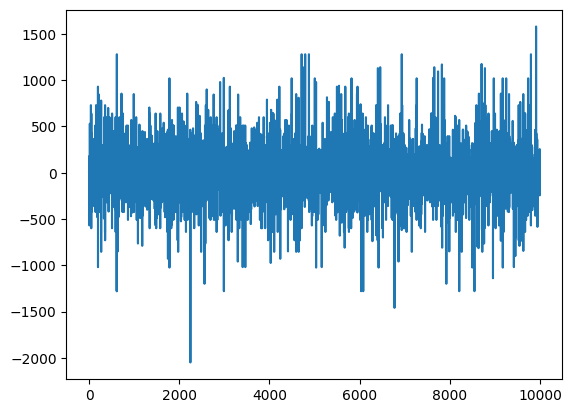

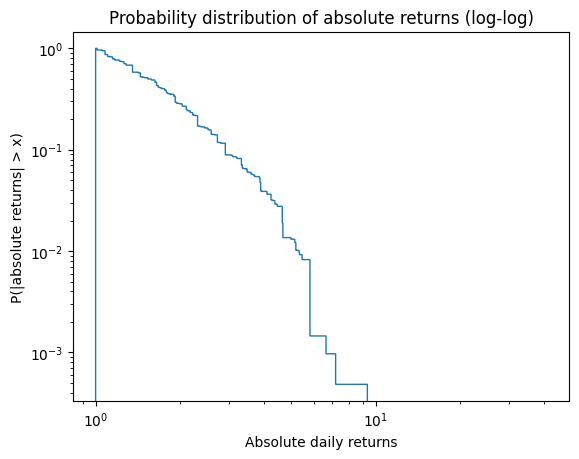

In [ ]:
# logarithmic bins
bin=np.logspace(start=0, stop=np.log(5), num=t)

# normalised returns
returns = [(abs(day) - np.mean(model_test.daily_returns)) / np.std(model_test.daily_returns) for day in model_test.daily_returns]

plt.plot(model_test.daily_returns)
plt.show()

plt.figure(1)
plt.hist(returns, bin, cumulative=-1, density=True, log=True, histtype='step')
plt.title("Probability distribution of absolute returns (log-log)")
plt.xlabel("Absolute daily returns")
plt.ylabel("P(|absolute returns| > x)")
plt.gca().set_xscale("log")
plt.show()


In [ ]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []

        # distribution of agents in different time horizons
        # agents are allocated to each time horizon (with exponential decay as we go back in time), until we reach the limit M
        # or until we reach the beginning of the simulation (if current timestep t < M)
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        # Agents only factor in the returns at the previous timestep
        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        # Agents look back M timesteps
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

In [ ]:
# Stochastic simulation

stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)

for i in range(t):
    stochastic.step()
    stochastic_horizons.step()

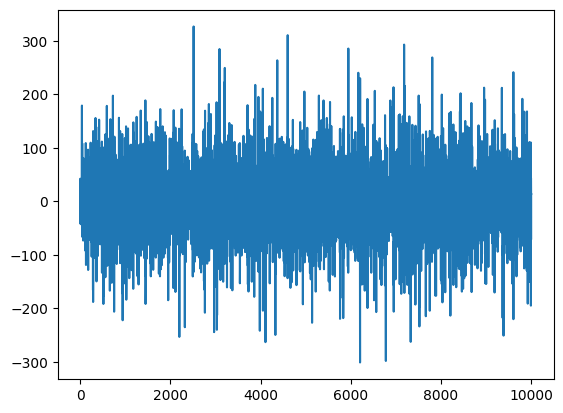

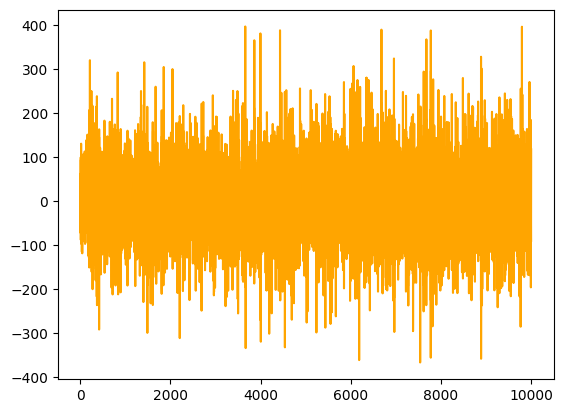

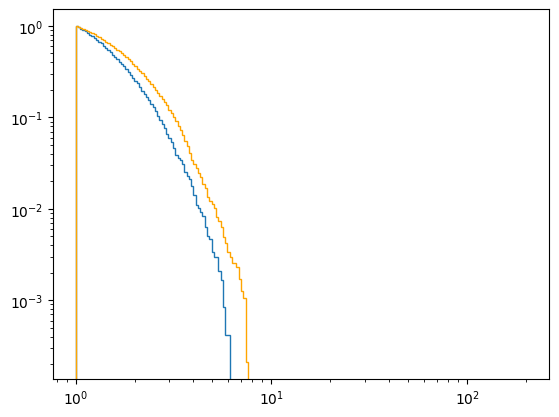

In [ ]:
#stochastic simulation return plots
plt.plot(range(t + 1), stochastic.returns)
plt.show()

plt.plot(range(t+1), stochastic_horizons.returns, color='orange')
plt.show()

abs_returns = [(abs(i) - np.mean(stochastic.returns)) / (np.std(stochastic.returns)) for i in stochastic.returns]
abs_returns_horizons = [(abs(i) - np.mean(abs_returns)) / (np.std(stochastic.returns)) for i in stochastic_horizons.returns]
bin=np.logspace(start=0, stop=np.log(10), num=200)

plt.hist(abs_returns, bins=bin, cumulative=-1, density=True, log=True, histtype='step')
plt.hist(abs_returns_horizons, bin, cumulative=-1, density=True, log=True, histtype='step', color = 'orange')
plt.gca().set_xscale("log")
plt.show()

In [ ]:
# importing data
df_adj_close_clean = pd.read_csv('data/df_adj_close_clean.csv')
df_open_clean = pd.read_csv('data/df_open_clean.csv')
# changing index to datetime 
df_adj_close_clean.index = pd.to_datetime(df_adj_close_clean['Date'])
df_open_clean.index = pd.to_datetime(df_open_clean['Date'])
# dropping date column
df_adj_close_clean = df_adj_close_clean.drop(columns=['Date'])
df_open_clean = df_open_clean.drop(columns=['Date'])

# calculation of returns following feng et al. (2012) method:
df_real_returns_log_difference = df_adj_close_clean.apply(np.log) - df_open_clean.apply(np.log)

# taking absolute of real returns
df_real_returns_log_difference_abs = df_real_returns_log_difference.abs()

# taking pct change returns
df_real_returns_pct_change = ((df_adj_close_clean - df_open_clean)/df_open_clean).dropna()


# pct change returns v2
df_real_returns_pct_change_v2 = df_adj_close_clean.pct_change().dropna()

# pct change returns v3 
df_real_returns_pct_change_v3 = df_open_clean.pct_change().dropna()

In [ ]:
real_returns_pct_change_flattened = df_real_returns_pct_change.abs().dropna().values.flatten()

In [ ]:
real_returns_log_difference_abs_flattened = df_real_returns_log_difference_abs.values.flatten()

In [ ]:
real_returns_pct_change_flattened_v2 = df_real_returns_pct_change_v2.abs().values.flatten()

In [ ]:
real_returns_pct_change_v3 = df_real_returns_pct_change_v3.abs().values.flatten()

(array([1.00000000e+00, 9.88232932e-01, 9.77981261e-01, ...,
        8.58095834e-07, 8.58095834e-07, 8.58095834e-07]),
 array([0.00000000e+00, 1.49186488e-04, 2.98372977e-04, ...,
        7.45634069e-01, 7.45783255e-01, 7.45932442e-01]),
 [<matplotlib.patches.Polygon at 0x241e69d8c70>])

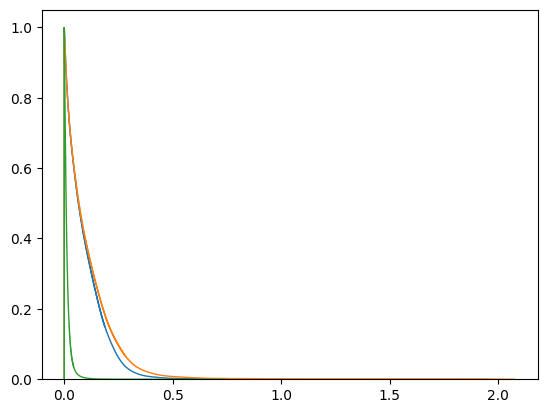

In [ ]:
# plotting histogram of 3 types of absolute returns
plt.hist(real_returns_pct_change_flattened, density=1, bins = 5000, cumulative=-1, histtype='step')
plt.hist(real_returns_log_difference_abs_flattened, density=1, bins = 5000, cumulative=-1, histtype='step')
plt.hist(real_returns_pct_change_flattened_v2, density=1, bins = 5000, cumulative=-1, histtype='step')


In [ ]:
def Hills_estimator(input:list)->float:
    # Hills estimator for fat tails
    # Reference: code for hills estimator for fitting of fat tails of distributions from : https://www.financialriskforecasting.com/code/MATLABPython9.html
    # free to use under GNU GPL license https://www.gnu.org/licenses/#GPL
    input
    input_sort = np.sort(input)   # sort the returns
    CT = 100   # set the threshold
    iota = 1/(np.mean(np.log(input_sort[0:CT]/input_sort[CT]))) # get the tail index
    print(iota)

In [ ]:
y_1_stoch = np.array(abs_returns_horizons)
y_2_stoch = np.array(abs_returns)
y_3_ABM = np.array(returns)

return_datasets = [y_1_stoch, y_2_stoch, y_3_ABM, real_returns_pct_change_flattened, real_returns_log_difference_abs_flattened, real_returns_pct_change_flattened_v2, real_returns_pct_change_v3]
labels = ['Stochastic model with time horizons', 'Stochastic model without time horizons', 'Agent based model', 'Real returns pct change', 'Real returns log difference', 'Real returns pct change v2', 'Real returns pct change v3']


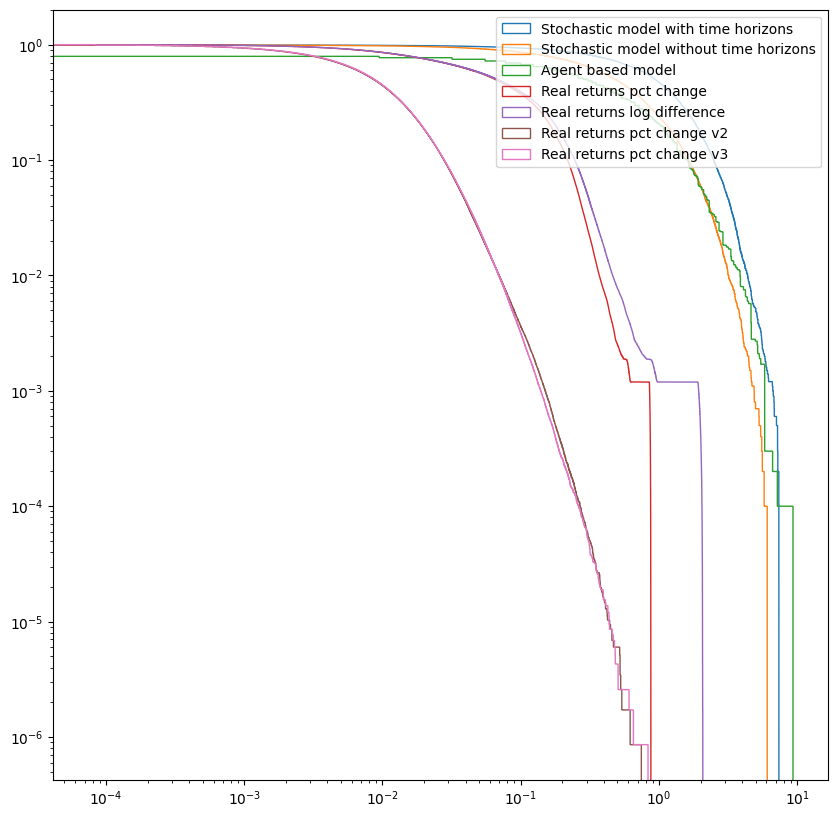

In [ ]:
# non-log plot
plt.figure(figsize=(10,10))
for i in range(len(return_datasets)):
    plt.hist(return_datasets[i], bins=10000, cumulative=-1, density=True, log=True, histtype='step', label = labels[i])
plt.legend()
plt.gca().set_xscale("log")
plt.legend()
plt.show()

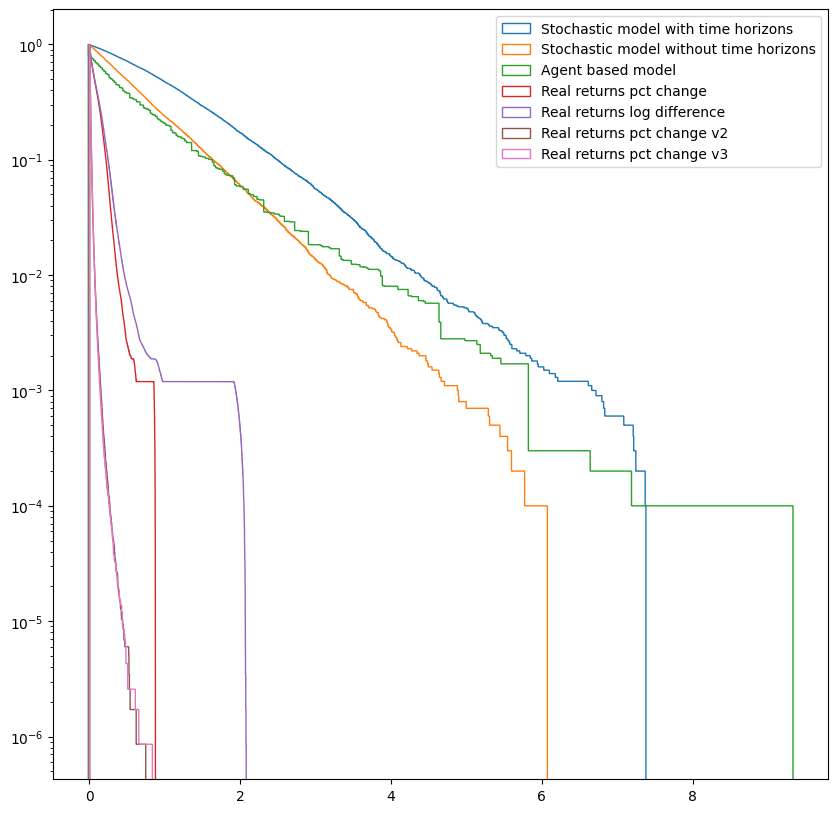

In [ ]:
# non-log plot
plt.figure(figsize=(10,10))
for i in range(len(return_datasets)):
    plt.hist(return_datasets[i], bins=10000, cumulative=-1, density=True, log=True, histtype='step', label = labels[i])
plt.legend()
plt.legend
plt.show()

In [ ]:
# code for kolmogorov-smirnov test for similarity of distributions: reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# assumed samples are independent

# making a matrix in which ks test results will be visualised

array_for_ks_test_results = np.zeros(((len(return_datasets), len(return_datasets))))
for i in range(len(return_datasets)):
    for j in range(len(return_datasets)):
        # returning the 1st element of ks test result as this is the p-value of the ks test
        # print(stats.kstest(return_datasets[i], return_datasets[j])[1])
            array_for_ks_test_results[i,j] = stats.kstest(return_datasets[i], return_datasets[j])[1]

IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
df_of_kstest_results = pd.DataFrame(array_for_ks_test_results)
df_of_kstest_results

,0,1,2,3
0,1.000000e+00,2.352081e-244,0.000000e+00,0.0
1,2.352081e-244,1.000000e+00,6.308059e-194,0.0
2,0.000000e+00,6.308059e-194,1.000000e+00,0.0
3,0.000000e+00,0.000000e+00,0.000000e+00,1.0


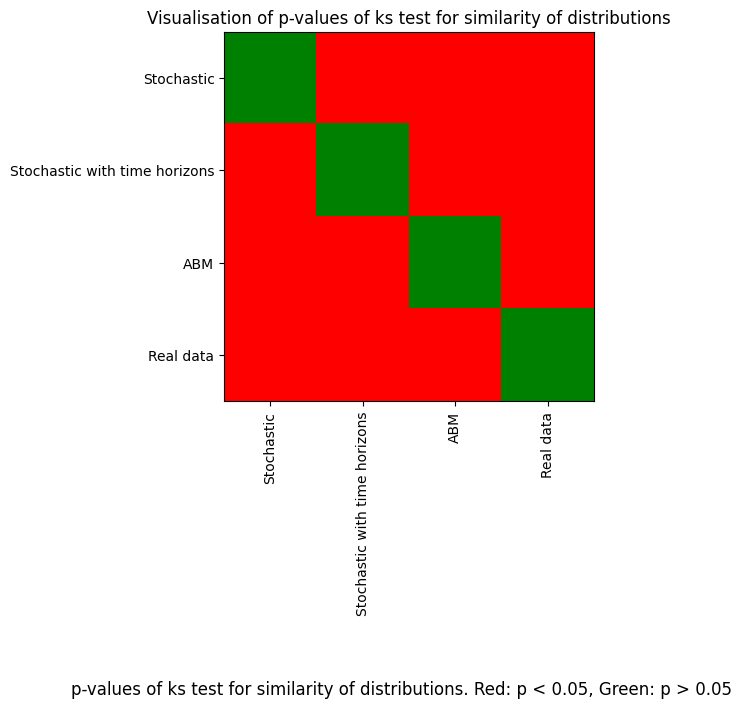

In [ ]:
color_matrix = np.where(array_for_ks_test_results < 0.05, 0,1)
cmap = (mpl.colors.ListedColormap(['red', 'green']))
plt.imshow(color_matrix, cmap=cmap, vmin=0, vmax=1)
plt.xticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'], rotation = 90)
plt.yticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'])
plt.title("Visualisation of p-values of ks test for similarity of distributions")
plt.figtext(0.5, -0.5, "p-values of ks test for similarity of distributions. Red: p < 0.05, Green: p > 0.05", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [ ]:
def regression(data_x, data_y, alpha, beta, learning_rate, iterations):
    rmse = math.sqrt(np.mean([((alpha + beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))]))

    for i in range(iterations):
        # find differentials of the parametres
        diff_alpha = 2 * np.mean([(data_x[i] * beta) for i in range(len(data_y))])
        diff_beta = 2 * np.mean([(data_x[i] * beta) * data_x[i] for i in range(len(data_y))])

        alpha_new = alpha - (learning_rate * diff_alpha)
        beta_new = beta - (learning_rate * diff_beta)

        rmse_zero_new = math.sqrt(np.mean([((alpha + beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))]))

        # keep new parametres if they lead to smaller rmse
        if rmse_zero_new < rmse_zero[-1]:
            alpha = alpha_new
            beta = beta_new
            rmse_zero = rmse_zero_new

    return alpha, beta, rmse

In [ ]:
def r_squared(data, alpha, beta, x_range):
    """
    Goodness of fit test for regression
    """
    ss_res = []
    ss_total = []
    mean = np.mean(data)

    for i in range(x_range):
        prediction = alpha + beta * x_range[i]
        value = data[i]

        residual = (value - prediction) ** 2
        total = (value - mean) ** 2

        ss_res.append(residual)
        ss_total.append(total)

    return 1 - (ss_res / ss_total)


In [ ]:
# k_test - think about ways to fit a power law
k_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in k_range:
    k = i
    k_test = Model(p, n, k, omega)
    for step in range(t):
        k_test.step()

    variance = np.std(k_test) ** 2
    variances.append(variance)

TypeError: Model.__init__() missing 1 required positional argument: 'omega'

In [ ]:
# k - regression (if beta > 0, there is a relationship)
k_r = regression(k_range, variances, 0, 10, 1000)
k_test = r_squared(variances, k_r[0], k_r[1], k_range)


In [ ]:
# omega_test - think about ways to fit a power law
omega_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in omega_range:
    omega = i
    omega_test = Model(p, n, k, omega)
    for step in range(t):
        omega_test.step()

    variance = np.std(omega_test) ** 2
    variances.append(variance)

In [ ]:
# omega - calculate regression of power law exponent and variances
omega_r = regression(omega_range, variances, 3, 2)
omega_test = r_squared(variances, omega_r[0], omega_r[1], omega_range)


In [ ]:
# p_test - variances; mean number of zeros
p_range = [i*0.01 for i in range(1, 101)]
variances = []
zeros = []

for i in p_range:
    p = i
    p_test = Model(p, n, 1, k, omega)
    for step in range(t):
        p_test.step()

    variance = np.std(p_test) ** 2
    variances.append(variance)

    for i in p_test.daily_returns:
        zero = []
        if -0.5 < i < 0.5:
            zero.append(i)
        
        zero_add = sum(zero) / len(p_test.daily_returns)
        zeros.append(zero_add)

KeyboardInterrupt: 

In [ ]:
p_zeros_r = regression(p_range, zeros, 5, 5, 1, 1000)
p_variances_r = regression(p_range, variances, 5, 5, 1, 1000)

p_test_zeros = r_squared(zeros, p_zeros_r[0], p_zeros_r[1], p_range)
p_test_variances = r_squared(variances, p_variances_r[0], p_variances_r[1], p_range)



NameError: name 'zeros' is not defined

In [ ]:
# Example of parameter generation
parameters = np.arange(0, 10, 1)
print("parameters to test:", parameters)


def gridsearch(real, abm_or_stoch, parameters):
    best_param = 0
    best_loss = 1000000000
    for param in parameters:
        if abm_or_stoch == 'abm':
            model_test = Model(p, n, size, k, omega) # change the parameter to test to "param"
            for i in range(t):
                model_test.step()
            abs_returns = [abs(day) for day in model_test.daily_returns]
            result = np.array(abs_returns)
        else:
            stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
            stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)
            for i in range(t):
                stochastic.step()
                stochastic_horizons.step()
            abs_returns = [abs(i) for i in stochastic.returns]
            result = np.array(abs_returns)
        rmse = np.sqrt(mean_squared_error(real, result))
        if rmse < best_loss:
            best_param = current_param
            best_loss = rmse
    return best_param, best_loss

# Implementation from https://archive.lib.msu.edu/crcmath/math/math/l/l142.html
def exp_lsq(x, y):
    n = len(bin) # sample size?
    ln_y = np.log(y, where= y != 0)
    sum_ln_y = np.sum(ln_y)
    sum_x = np.sum(x)
    sum_x_ln_y = np.sum(x * ln_y)
    print('sum_ln_y', sum_ln_y, 'sum_x', sum_x)
    a = (sum_ln_y * sum_x**2 - sum_x*sum_x_ln_y) / (n * np.sum(x**2) - sum_x**2)
    b = (n * sum_x_ln_y - sum_x*sum_ln_y)/(n * np.sum(x**2) - sum_x**2)
    return a, b

In [ ]:
a, b = exp_lsq(bin, real_bins)
print(a,b)
x = np.arange(0, len(bin), 1)
y = np.exp(a)*math.e**(b*x)
plt.scatter(x,y)